In [1]:
# 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid

%matplotlib inline

'''데이터 준비 및 모델 평가 관련 라이브러리'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''알고리즘 관련 라이브러리'''
import lightgbm as lgb

'''텐서플로 및 케라스 관련 라이브러리'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy

Using TensorFlow backend.


In [2]:
# 데이터 로드
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'mnist_data', 'mnist.pkl.gz'])
f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [3]:
# 데이터 셋 구조 확인
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


In [4]:
# 데이터 셋으로부터 판다스 데이터 프레임 만들기
train_index = range(0,len(X_train))
validation_index = range(len(X_train),len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), \
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [5]:
# 훈련 데이터의 요약 결과 생성
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022778,0.015422,0.012079,0.007217,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992188,0.992188,0.988281,0.988281,0.992188,0.242188,0.0,0.0,0.0,0.0


In [6]:
# 레이블 데이터 보기
y_train.head()

0    5
1    0
2    4
3    1
4    9
dtype: int64

In [7]:
def view_digit(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d  Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

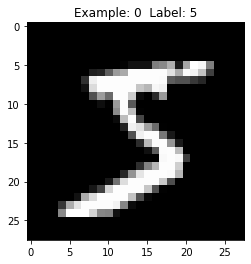

In [8]:
# 첫번째 숫자 이미지 보기
view_digit(X_train, y_train, 0)

In [9]:
def one_hot(series):
    label_binarizer = pp.LabelBinarizer()
    label_binarizer.fit(range(max(series)+1))
    return label_binarizer.transform(series)

In [10]:
def reverse_one_hot(originalSeries, newSeries):
    label_binarizer = pp.LabelBinarizer()
    label_binarizer.fit(range(max(originalSeries)+1))
    return label_binarizer.inverse_transform(newSeries)

In [11]:
# 레이블에 대한 원-핫 벡터 생성
y_train_oneHot = one_hot(y_train)
y_validation_oneHot = one_hot(y_validation)
y_test_oneHot = one_hot(y_test)

In [12]:
# 숫자 5인 첫번째 샘플에 대한 원-핫 벡터 보기 
y_train_oneHot[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [13]:
# RBM 클래스 정의
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # 하이퍼파라미터 정의
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # 제로 행렬을 사용한 편향 및 가중치 초기화
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), \
                        self.batchsize),range(self.batchsize,len(X), \
                                              self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, \
                                _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)
        
    def show_features(self, shape, suptitle, count=-1):
        maxw = np.amax(self.w.T)
        minw = np.amin(self.w.T)
        count = self._output_size if count == -1 or count > \
                self._output_size else count
        ncols = count if count < 14 else 14 
        nrows = count//ncols
        nrows = nrows if nrows > 2 else 3
        fig = plt.figure(figsize=(ncols, nrows), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

        for i, ax in enumerate(grid):
            x = self.w.T[i] if i<self._input_size else np.zeros(shape)
            x = (x.reshape(1, -1) - minw)/maxw
            ax.imshow(x.reshape(*shape), cmap=mpl.cm.Greys)
            ax.set_axis_off()

        fig.text(0.5,1, suptitle, fontsize=20, horizontalalignment='center')
        fig.tight_layout()
        plt.show()
        return

In [14]:
# 훈련 데이터 셋을 InputX 로 설정하기
inputX = np.array(X_train)
inputX = inputX.astype(np.float32) ####

# RBMS 보유 목록 생성
rbm_list = []

# 훈련을 위한 RBMs 파라미터 정의 
rbm_list.append(RBM(784,700,1.0,100,200))
rbm_list.append(RBM(700,600,1.0,100,200))
rbm_list.append(RBM(600,500,1.0,100,200))

In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13111466376210185259
]


In [16]:
outputList = []
error_list = []
# 목록에서 각 RBM을 적용하기 위함
for i in range(0,len(rbm_list)):
    print('RBM', i+1)
    # 새로운 RBM을 훈련
    rbm = rbm_list[i]
    err = rbm.train(inputX)
    error_list.append(err)
    # 출력층을 다음 입력층으로 반환 
    outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)
    outputList.append(outputX)
    inputX = hiddenX

RBM 1
Instructions for updating:
Use `tf.cast` instead.
Epoch: 0 reconstruction error: 0.075755
Epoch: 1 reconstruction error: 0.065165
Epoch: 2 reconstruction error: 0.059219
Epoch: 3 reconstruction error: 0.055618
Epoch: 4 reconstruction error: 0.052843
Epoch: 5 reconstruction error: 0.050864
Epoch: 6 reconstruction error: 0.049290
Epoch: 7 reconstruction error: 0.047826
Epoch: 8 reconstruction error: 0.046799
Epoch: 9 reconstruction error: 0.045853
Epoch: 10 reconstruction error: 0.045670
Epoch: 11 reconstruction error: 0.045122
Epoch: 12 reconstruction error: 0.044661
Epoch: 13 reconstruction error: 0.043783
Epoch: 14 reconstruction error: 0.043739
Epoch: 15 reconstruction error: 0.043008
Epoch: 16 reconstruction error: 0.042923
Epoch: 17 reconstruction error: 0.043006
Epoch: 18 reconstruction error: 0.042355
Epoch: 19 reconstruction error: 0.042042
Epoch: 20 reconstruction error: 0.042094
Epoch: 21 reconstruction error: 0.041818
Epoch: 22 reconstruction error: 0.041590
Epoch: 23 r

Epoch: 95 reconstruction error: 0.021250
Epoch: 96 reconstruction error: 0.021156
Epoch: 97 reconstruction error: 0.021204
Epoch: 98 reconstruction error: 0.021106
Epoch: 99 reconstruction error: 0.021085
RBM 3
Epoch: 0 reconstruction error: 0.028431
Epoch: 1 reconstruction error: 0.023867
Epoch: 2 reconstruction error: 0.021690
Epoch: 3 reconstruction error: 0.020855
Epoch: 4 reconstruction error: 0.019740
Epoch: 5 reconstruction error: 0.019013
Epoch: 6 reconstruction error: 0.018518
Epoch: 7 reconstruction error: 0.018025
Epoch: 8 reconstruction error: 0.017562
Epoch: 9 reconstruction error: 0.017373
Epoch: 10 reconstruction error: 0.016968
Epoch: 11 reconstruction error: 0.016728
Epoch: 12 reconstruction error: 0.016654
Epoch: 13 reconstruction error: 0.016243
Epoch: 14 reconstruction error: 0.016149
Epoch: 15 reconstruction error: 0.015895
Epoch: 16 reconstruction error: 0.015852
Epoch: 17 reconstruction error: 0.015637
Epoch: 18 reconstruction error: 0.015521
Epoch: 19 reconstruc

RBM 1


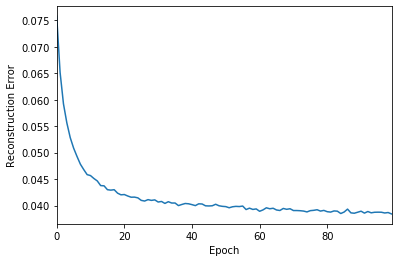

RBM 2


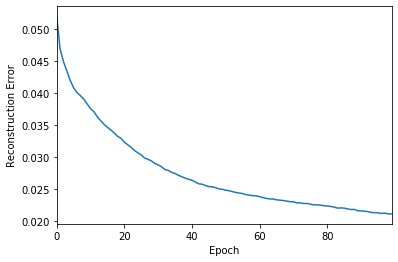

RBM 3


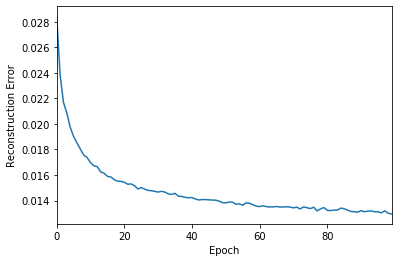

In [17]:
# 재구성 오차 그래프
i = 1
for err in error_list:
    print("RBM",i)
    pd.Series(err).plot(logy=False)
    plt.xlabel("Epoch")
    plt.ylabel("Reconstruction Error")
    plt.show()
    i += 1

RBM 0


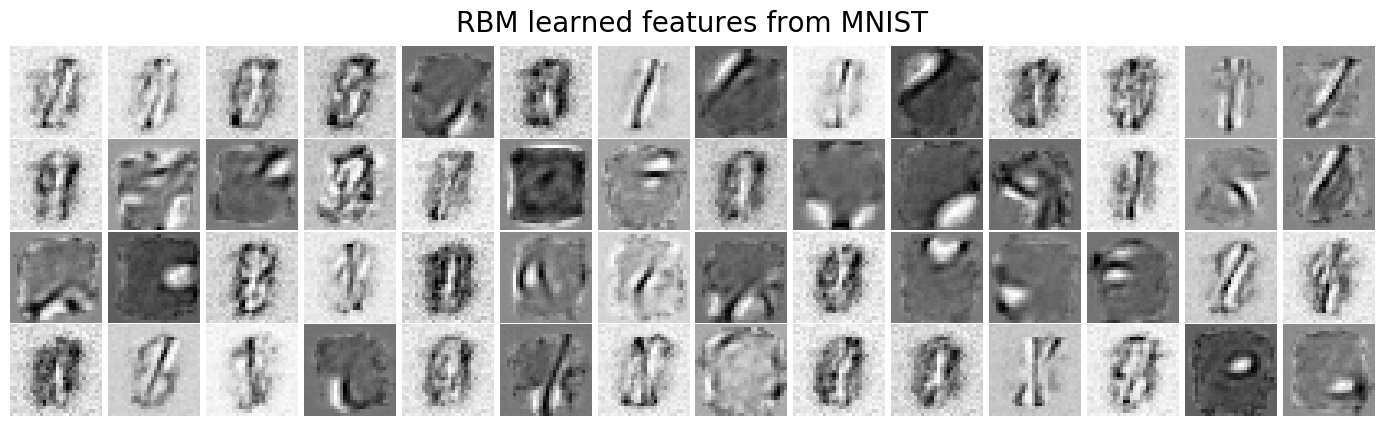

None
RBM 1


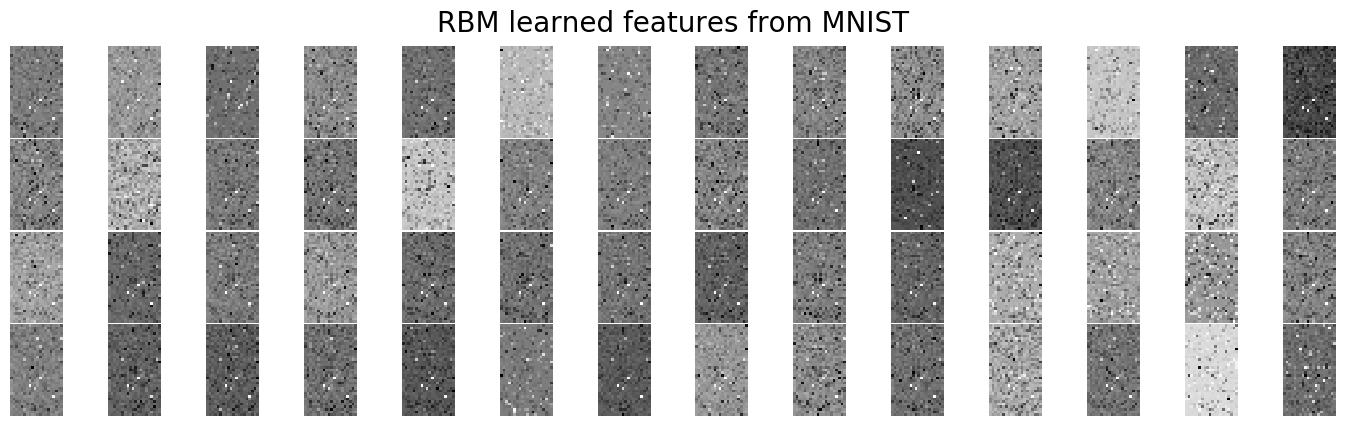

None
RBM 2


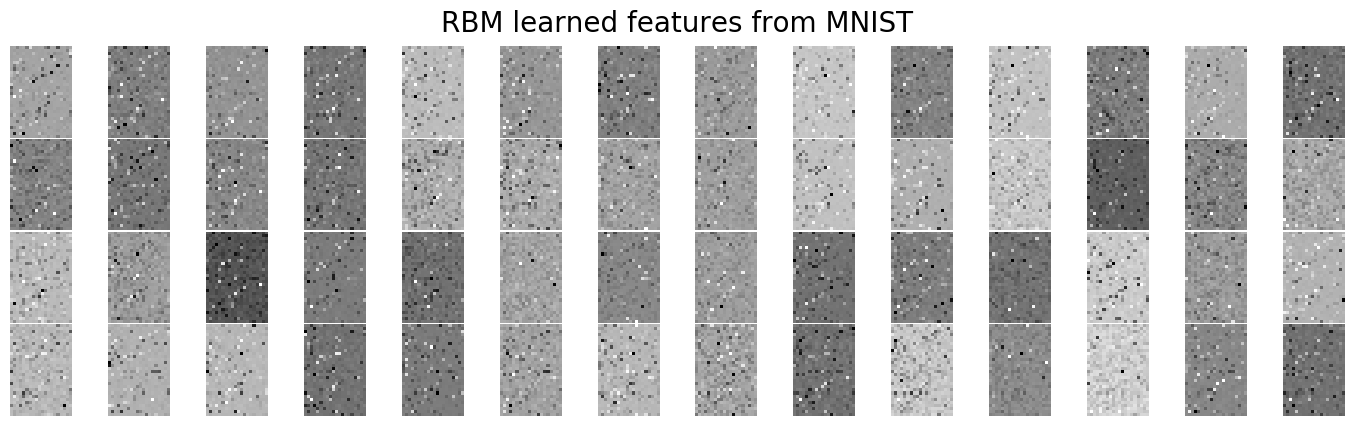

None


In [18]:
# 피처 추출기 확인
rbm_shapes = [(28,28),(35,20),(30,20)] ####
for i in range(0,len(rbm_list)):
    rbm = rbm_list[i]
    print("RBM",i)
    print(rbm.show_features(rbm_shapes[i], \
                            "RBM learned features from MNIST", 56))

RBM 1
Image generated by RBM


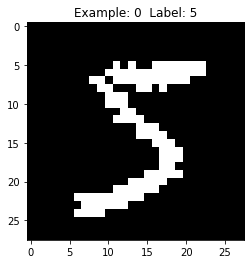

Original image


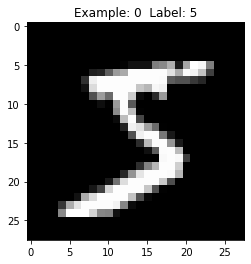

Image generated by RBM


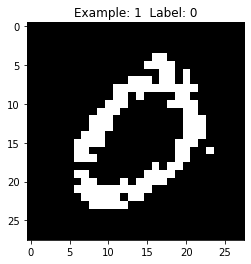

Original image


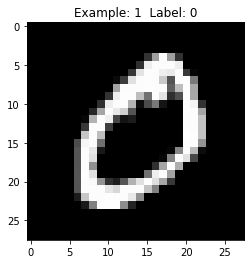

Image generated by RBM


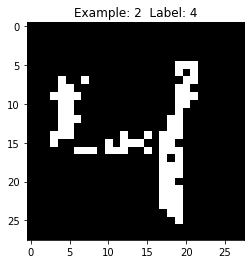

Original image


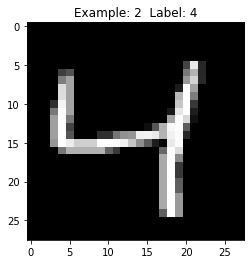

Image generated by RBM


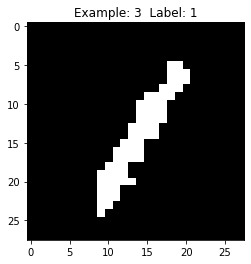

Original image


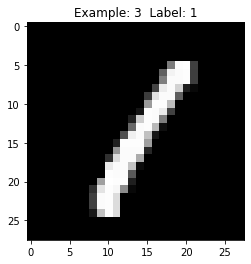

Image generated by RBM


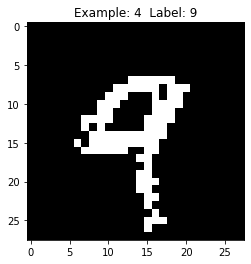

Original image


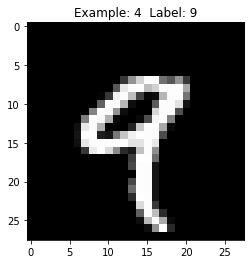

Image generated by RBM


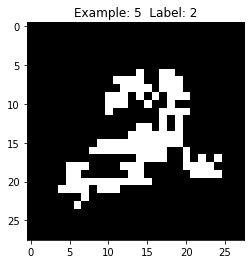

Original image


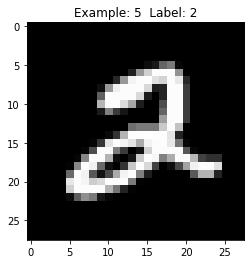

Image generated by RBM


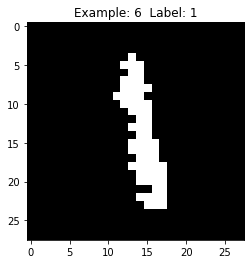

Original image


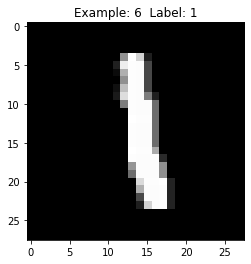

Image generated by RBM


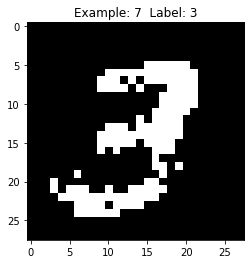

Original image


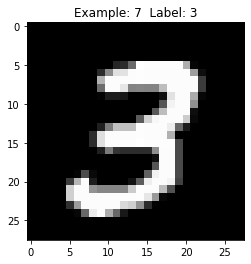

Image generated by RBM


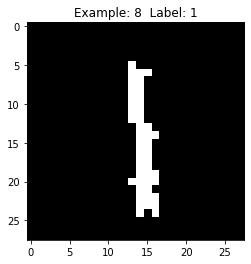

Original image


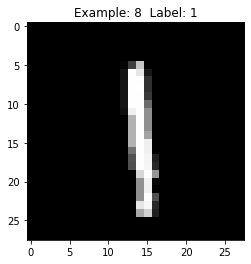

Image generated by RBM


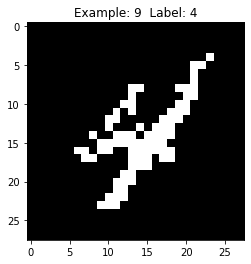

Original image


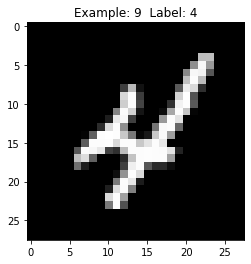

In [19]:
# 첫번째 RBM으로부터 생성된 이미지 보기
inputX = np.array(X_train)
rbmOne = rbm_list[0]

print('RBM 1')
outputX_rbmOne, reconstructedX_rbmOne, hiddenX_rbmOne = \
                            rbmOne.rbm_output(inputX)
reconstructedX_rbmOne = pd.DataFrame(data=reconstructedX_rbmOne, \
                                     index=X_train.index)
for j in range(0,10):
    example = j
    print("Image generated by RBM")
    view_digit(reconstructedX_rbmOne, y_train, example)
    print("Original image")
    view_digit(X_train, y_train, example)

In [20]:
class DBN(object):
    def __init__(self, original_input_size, input_size, output_size, 
                 learning_rate, epochs, batchsize, rbmOne, rbmTwo, rbmThree):
        # 하이퍼파라미터 정의
        self._original_input_size = original_input_size
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        self.rbmOne = rbmOne
        self.rbmTwo = rbmTwo
        self.rbmThree = rbmThree
    
        self.w = np.zeros([input_size, output_size], "float")
        self.hb = np.zeros([output_size], "float")
        self.vb = np.zeros([input_size], "float")
    
    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], "float")
        prv_hb = np.zeros([self._output_size], "float")
        prv_vb = np.zeros([self._input_size], "float")
        
        cur_w = np.zeros([self._input_size, self._output_size], "float")
        cur_hb = np.zeros([self._output_size], "float")
        cur_vb = np.zeros([self._input_size], "float")
        
        v0 = tf.placeholder("float", [None, self._original_input_size])

        forwardOne = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(v0, \
                        self.rbmOne.w) + self.rbmOne.hb) - tf.random_uniform( \
                        tf.shape(tf.nn.sigmoid(tf.matmul(v0, self.rbmOne.w) + \
                        self.rbmOne.hb)))))
        forwardTwo = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(forwardOne, \
                        self.rbmTwo.w) + self.rbmTwo.hb) - tf.random_uniform( \
                        tf.shape(tf.nn.sigmoid(tf.matmul(forwardOne, \
                        self.rbmTwo.w) + self.rbmTwo.hb)))))
        forward = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(forwardTwo, \
                        self.rbmThree.w) + self.rbmThree.hb) - \
                        tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul( \
                        forwardTwo, self.rbmThree.w) + self.rbmThree.hb)))))
        h0 = self.sample_prob(self.prob_h_given_v(forward, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(forward), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / \
                        tf.to_float(tf.shape(forward)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(forward - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        backwardOne = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(v1, \
                            self.rbmThree.w.T) + self.rbmThree.vb) - \
                            tf.random_uniform(tf.shape(tf.nn.sigmoid( \
                            tf.matmul(v1, self.rbmThree.w.T) + \
                            self.rbmThree.vb)))))
        backwardTwo = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(backwardOne, \
                            self.rbmTwo.w.T) + self.rbmTwo.vb) - \
                            tf.random_uniform(tf.shape(tf.nn.sigmoid( \
                            tf.matmul(backwardOne, self.rbmTwo.w.T) + \
                            self.rbmTwo.vb)))))
        backward = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(backwardTwo, \
                            self.rbmOne.w.T) + self.rbmOne.vb) - \
                            tf.random_uniform(tf.shape(tf.nn.sigmoid( \
                            tf.matmul(backwardTwo, self.rbmOne.w.T) + \
                            self.rbmOne.vb)))))
        
        err = tf.reduce_mean(tf.square(v0 - backward))
        error_list = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), self.batchsize), \
                        range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: \
                                        prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: \
                                        prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: \
                                        prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: \
                                    cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list
        
    def dbn_output(self, X):

        input_X = tf.constant(X)
        forwardOne = tf.nn.sigmoid(tf.matmul(input_X, self.rbmOne.w) + \
                                   self.rbmOne.hb)
        forwardTwo = tf.nn.sigmoid(tf.matmul(forwardOne, self.rbmTwo.w) + \
                                   self.rbmTwo.hb)
        forward = tf.nn.sigmoid(tf.matmul(forwardTwo, self.rbmThree.w) + \
                                self.rbmThree.hb)

        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)

        out = tf.nn.sigmoid(tf.matmul(forward, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(forward, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))

        backwardTwo = tf.nn.sigmoid(tf.matmul(visibleGen, self.rbmThree.w.T) + \
                                    self.rbmThree.vb)
        backwardOne = tf.nn.sigmoid(tf.matmul(backwardTwo, self.rbmTwo.w.T) + \
                                    self.rbmTwo.vb)
        backward = tf.nn.sigmoid(tf.matmul(backwardOne, self.rbmOne.w.T) + \
                                 self.rbmOne.vb)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(backward)

    def show_features(self, shape, suptitle, count=-1):
        maxw = np.amax(self.w.T)
        minw = np.amin(self.w.T)
        count = self._output_size if count == -1 or count > \
                self._output_size else count
        ncols = count if count < 14 else 14 
        nrows = count//ncols
        nrows = nrows if nrows > 2 else 3
        fig = plt.figure(figsize=(ncols, nrows), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

        for i, ax in enumerate(grid):
            x = self.w.T[i] if i<self._input_size else np.zeros(shape)
            x = (x.reshape(1, -1) - minw)/maxw
            ax.imshow(x.reshape(*shape), cmap=mpl.cm.Greys)
            ax.set_axis_off()

        fig.text(0.5,1, suptitle, fontsize=20, horizontalalignment='center')
        fig.tight_layout()
        plt.show()
        return

In [21]:
# DBN 클래스 인스턴스화
dbn = DBN(784, 500, 500, 1.0, 50, 200, rbm_list[0], rbm_list[1], rbm_list[2])

In [22]:
inputX = np.array(X_train)
error_list = []
error_list = dbn.train(inputX)

Epoch: 0 reconstruction error: 0.089918
Epoch: 1 reconstruction error: 0.080316
Epoch: 2 reconstruction error: 0.077135
Epoch: 3 reconstruction error: 0.075402
Epoch: 4 reconstruction error: 0.074122
Epoch: 5 reconstruction error: 0.073165
Epoch: 6 reconstruction error: 0.072263
Epoch: 7 reconstruction error: 0.071704
Epoch: 8 reconstruction error: 0.070614
Epoch: 9 reconstruction error: 0.069913
Epoch: 10 reconstruction error: 0.069322
Epoch: 11 reconstruction error: 0.068751
Epoch: 12 reconstruction error: 0.068309
Epoch: 13 reconstruction error: 0.067867
Epoch: 14 reconstruction error: 0.067312
Epoch: 15 reconstruction error: 0.066909
Epoch: 16 reconstruction error: 0.066779
Epoch: 17 reconstruction error: 0.066415
Epoch: 18 reconstruction error: 0.065939
Epoch: 19 reconstruction error: 0.065643
Epoch: 20 reconstruction error: 0.065239
Epoch: 21 reconstruction error: 0.065060
Epoch: 22 reconstruction error: 0.064866
Epoch: 23 reconstruction error: 0.064404
Epoch: 24 reconstruction e

DBN


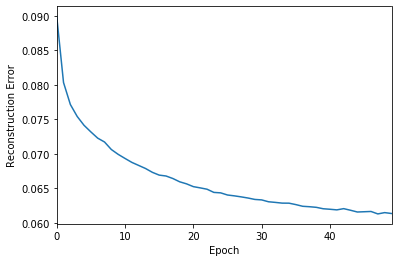

In [23]:
# 재구성 오차
print("DBN")
pd.Series(error_list).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")
plt.show()

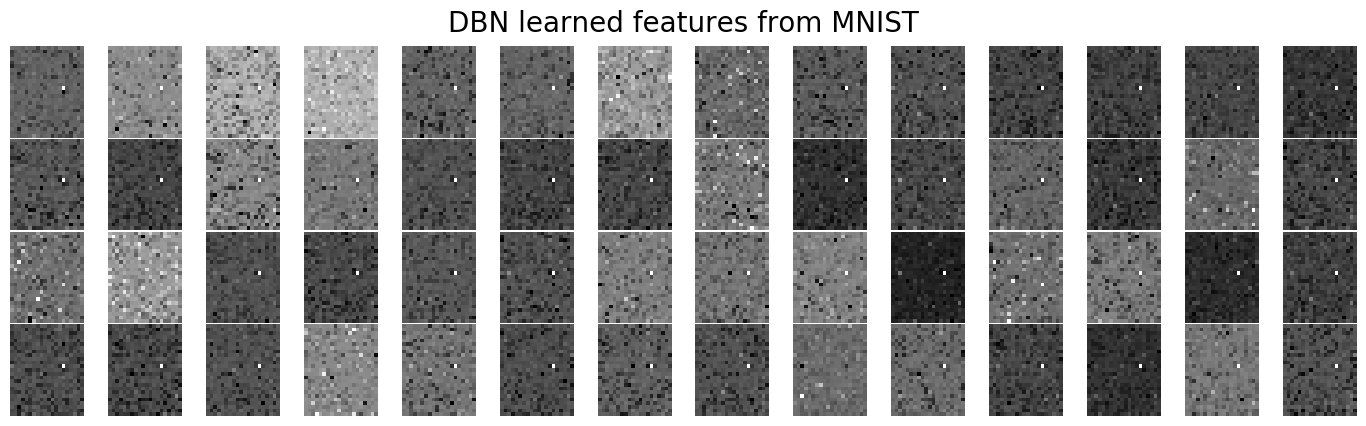

None


In [24]:
print(dbn.show_features((25,20),"DBN learned features from MNIST", 56))

In [25]:
# 이미지 생성 및 저장
inputXReduced = X_train.loc[:4999]
for i in range(0,20):
    print("Run ",i)
    finalOutput_DBN, reconstructedOutput_DBN = dbn.dbn_output(inputXReduced)
    if i==0:
        generatedImages = finalOutput_DBN
    else:
        generatedImages = np.append(generatedImages, finalOutput_DBN, axis=0)

Run  0
Run  1
Run  2
Run  3
Run  4
Run  5
Run  6
Run  7
Run  8
Run  9
Run  10
Run  11
Run  12
Run  13
Run  14
Run  15
Run  16
Run  17
Run  18
Run  19


In [26]:
# 생성된 이미지를 위한 레이블 벡터 생성
for i in range(0,20):
    if i==0:
        labels = y_train.loc[:4999]
    else:
        labels = np.append(labels,y_train.loc[:4999])

In [27]:
# 검증 셋 기반으로 이미지 생성
inputValidation = np.array(X_validation)
finalOutput_DBN_validation, reconstructedOutput_DBN_validation = \
    dbn.dbn_output(inputValidation)

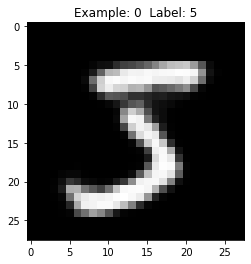

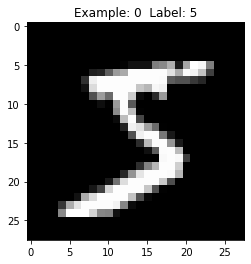

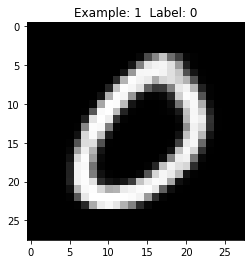

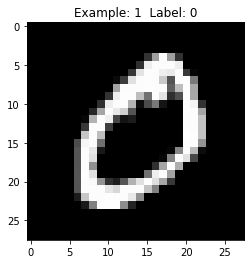

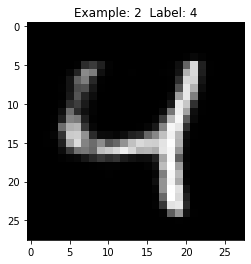

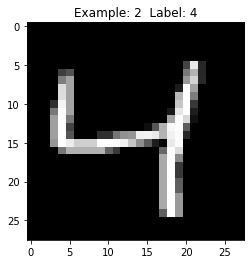

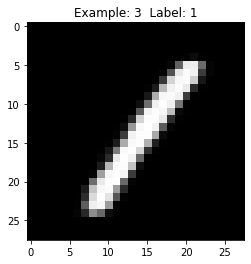

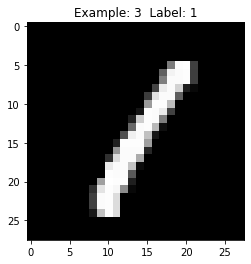

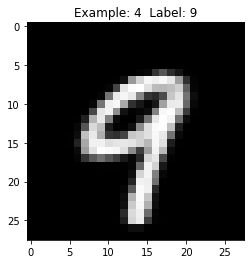

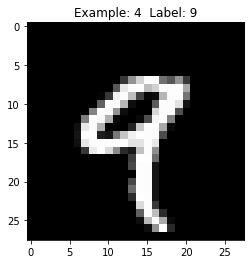

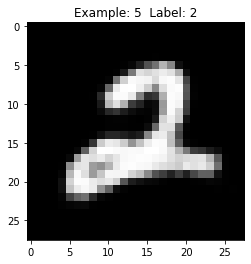

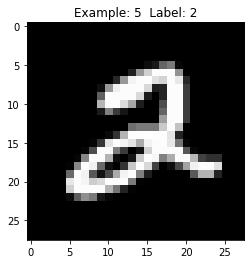

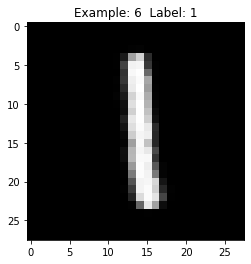

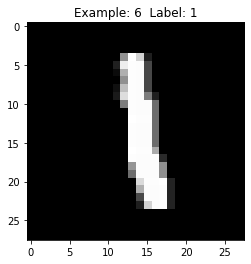

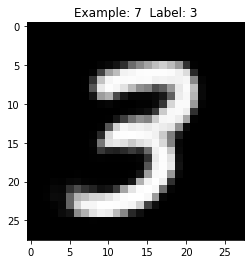

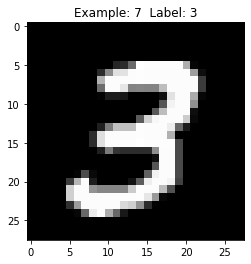

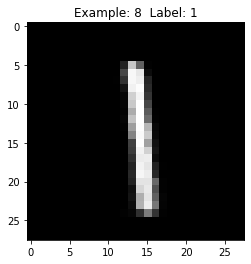

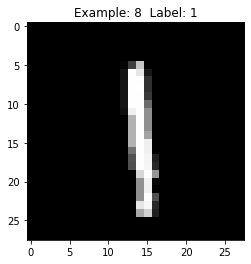

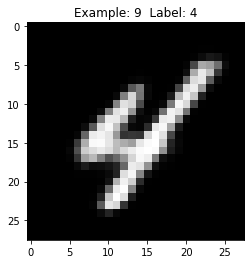

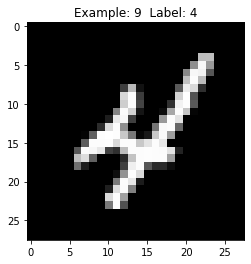

In [28]:
# 재구성된 몇 개의 이미지 보기
for i in range(0,10):
    example = i
    reconstructedX = pd.DataFrame(data=reconstructedOutput_DBN, \
                                  index=X_train[0:5000].index)
    view_digit(reconstructedX, y_train, example)
    view_digit(X_train, y_train, example)

Run  0
Generated


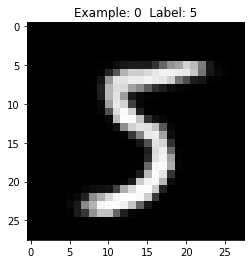

Run  1
Generated


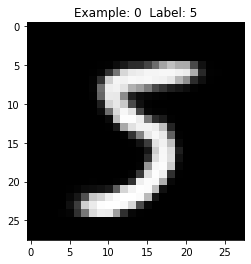

Run  2
Generated


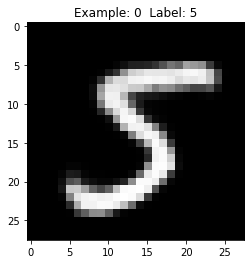

Run  3
Generated


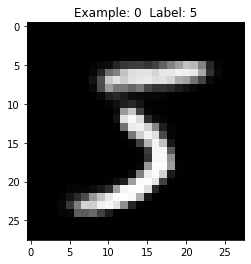

Run  4
Generated


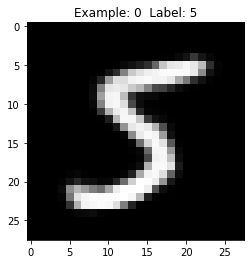

Run  5
Generated


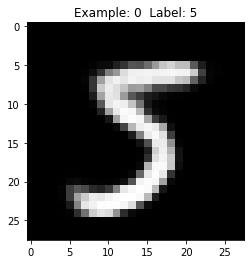

Run  6
Generated


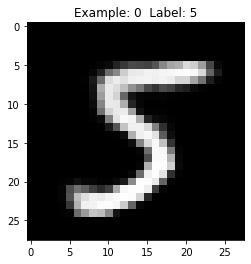

Run  7
Generated


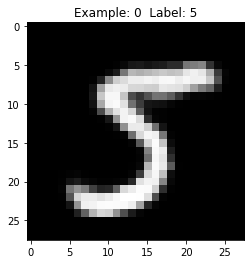

Run  8
Generated


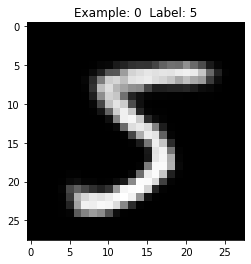

Run  9
Generated


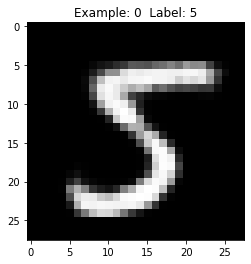

In [29]:
# 첫번째 샘플 기준 이미지 10번 생성
inputXReduced = X_train.loc[:0]
for i in range(0,10):
    example = 0
    print("Run ",i)
    finalOutput_DBN_fives, reconstructedOutput_DBN_fives = \
        dbn.dbn_output(inputXReduced)
    reconstructedX_fives = pd.DataFrame(data=reconstructedOutput_DBN_fives, \
                                        index=[0])
    print("Generated")
    view_digit(reconstructedX_fives, y_train.loc[:0], example)

In [30]:
# 지도 학습만

In [31]:
predictionColumns = ['0','1','2','3','4','5','6','7','8','9']

params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':10,
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [32]:
trainingScore = []
validationScore = []
predictionsLightGBM = pd.DataFrame(data=[], \
                        index=y_validation.index, \
                        columns=predictionColumns)

lgb_train = lgb.Dataset(X_train.loc[:4999], y_train.loc[:4999])
lgb_eval = lgb.Dataset(X_validation, y_validation, reference=lgb_train)
gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
loglossTraining = log_loss(y_train.loc[:4999], \
    gbm.predict(X_train.loc[:4999], num_iteration=gbm.best_iteration))
trainingScore.append(loglossTraining)
    
predictionsLightGBM.loc[X_validation.index,predictionColumns] = \
    gbm.predict(X_validation, num_iteration=gbm.best_iteration) 
loglossValidation = log_loss(y_validation, 
    predictionsLightGBM.loc[X_validation.index,predictionColumns])
validationScore.append(loglossValidation)
    
print('Training Log Loss: ', loglossTraining)
print('Validation Log Loss: ', loglossValidation)

loglossLightGBM = log_loss(y_validation, predictionsLightGBM)
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBM)

[1]	valid_0's multi_logloss: 2.03454
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's multi_logloss: 1.83525
[3]	valid_0's multi_logloss: 1.67519
[4]	valid_0's multi_logloss: 1.54476
[5]	valid_0's multi_logloss: 1.43551
[6]	valid_0's multi_logloss: 1.3405
[7]	valid_0's multi_logloss: 1.25821
[8]	valid_0's multi_logloss: 1.18576
[9]	valid_0's multi_logloss: 1.11769
[10]	valid_0's multi_logloss: 1.05417
[11]	valid_0's multi_logloss: 0.998275
[12]	valid_0's multi_logloss: 0.946335
[13]	valid_0's multi_logloss: 0.900563
[14]	valid_0's multi_logloss: 0.858236
[15]	valid_0's multi_logloss: 0.820315
[16]	valid_0's multi_logloss: 0.786376
[17]	valid_0's multi_logloss: 0.754031
[18]	valid_0's multi_logloss: 0.723755
[19]	valid_0's multi_logloss: 0.696682
[20]	valid_0's multi_logloss: 0.670898
[21]	valid_0's multi_logloss: 0.645592
[22]	valid_0's multi_logloss: 0.623957
[23]	valid_0's multi_logloss: 0.601312
[24]	valid_0's multi_logloss: 0.582042
[25]	valid_0's multi_

[208]	valid_0's multi_logloss: 0.191679
[209]	valid_0's multi_logloss: 0.191682
[210]	valid_0's multi_logloss: 0.191608
[211]	valid_0's multi_logloss: 0.191701
[212]	valid_0's multi_logloss: 0.191616
[213]	valid_0's multi_logloss: 0.191459
[214]	valid_0's multi_logloss: 0.19156
[215]	valid_0's multi_logloss: 0.191494
[216]	valid_0's multi_logloss: 0.191262
[217]	valid_0's multi_logloss: 0.191273
[218]	valid_0's multi_logloss: 0.191264
[219]	valid_0's multi_logloss: 0.190987
[220]	valid_0's multi_logloss: 0.190987
[221]	valid_0's multi_logloss: 0.190965
[222]	valid_0's multi_logloss: 0.190904
[223]	valid_0's multi_logloss: 0.190746
[224]	valid_0's multi_logloss: 0.190798
[225]	valid_0's multi_logloss: 0.190905
[226]	valid_0's multi_logloss: 0.190855
[227]	valid_0's multi_logloss: 0.190842
[228]	valid_0's multi_logloss: 0.190907
[229]	valid_0's multi_logloss: 0.191009
[230]	valid_0's multi_logloss: 0.191
[231]	valid_0's multi_logloss: 0.19109
[232]	valid_0's multi_logloss: 0.191126
[233]

[414]	valid_0's multi_logloss: 0.215497
[415]	valid_0's multi_logloss: 0.215573
[416]	valid_0's multi_logloss: 0.215772
[417]	valid_0's multi_logloss: 0.215744
[418]	valid_0's multi_logloss: 0.215796
[419]	valid_0's multi_logloss: 0.215835
[420]	valid_0's multi_logloss: 0.215898
[421]	valid_0's multi_logloss: 0.21606
[422]	valid_0's multi_logloss: 0.216311
[423]	valid_0's multi_logloss: 0.216515
Early stopping, best iteration is:
[223]	valid_0's multi_logloss: 0.190746
Training Log Loss:  0.0013000337911290725
Validation Log Loss:  0.19074588942001713
LightGBM Gradient Boosting Log Loss:  0.19074588942001713


In [33]:
predictionsLightGBM_firm = np.argmax(np.array(predictionsLightGBM), axis=1)
accuracyValidation_lightGBM = accuracy_score(np.array(y_validation), \
                                            predictionsLightGBM_firm)
print("Supervised-Only Accuracy: ", accuracyValidation_lightGBM)

Supervised-Only Accuracy:  0.9437


In [34]:
# 비지도 및 지도 학습 솔루션

In [35]:
# LightGBM 사용을 위한 DBN 기반 데이터 프레임 준비
generatedImagesDF = pd.DataFrame(data=generatedImages,index=range(0,100000))
labelsDF = pd.DataFrame(data=labels,index=range(0,100000))

X_train_lgb = pd.DataFrame(data=generatedImagesDF,
                           index=generatedImagesDF.index)
X_validation_lgb = pd.DataFrame(data=finalOutput_DBN_validation,
                                index=X_validation.index)

In [36]:
# Light GBM 훈련
trainingScore = []
validationScore = []
predictionsDBN = pd.DataFrame(data=[],index=y_validation.index,
                              columns=predictionColumns)

lgb_train = lgb.Dataset(X_train_lgb, labels)
lgb_eval = lgb.Dataset(X_validation_lgb, y_validation, reference=lgb_train)
gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
loglossTraining = log_loss(labelsDF, gbm.predict(X_train_lgb, \
                            num_iteration=gbm.best_iteration))
trainingScore.append(loglossTraining)
    
predictionsDBN.loc[X_validation.index,predictionColumns] = \
    gbm.predict(X_validation_lgb, num_iteration=gbm.best_iteration) 
loglossValidation = log_loss(y_validation, 
    predictionsDBN.loc[X_validation.index,predictionColumns])
validationScore.append(loglossValidation)
    
print('Training Log Loss: ', loglossTraining)
print('Validation Log Loss: ', loglossValidation)

loglossDBN = log_loss(y_validation, predictionsDBN)
print('LightGBM Gradient Boosting Log Loss: ', loglossDBN)

[1]	valid_0's multi_logloss: 1.93535
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's multi_logloss: 1.69311
[3]	valid_0's multi_logloss: 1.5117
[4]	valid_0's multi_logloss: 1.36576
[5]	valid_0's multi_logloss: 1.24397
[6]	valid_0's multi_logloss: 1.14029
[7]	valid_0's multi_logloss: 1.05083
[8]	valid_0's multi_logloss: 0.973478
[9]	valid_0's multi_logloss: 0.904382
[10]	valid_0's multi_logloss: 0.843558
[11]	valid_0's multi_logloss: 0.787559
[12]	valid_0's multi_logloss: 0.739072
[13]	valid_0's multi_logloss: 0.693942
[14]	valid_0's multi_logloss: 0.652659
[15]	valid_0's multi_logloss: 0.615368
[16]	valid_0's multi_logloss: 0.581115
[17]	valid_0's multi_logloss: 0.549903
[18]	valid_0's multi_logloss: 0.521724
[19]	valid_0's multi_logloss: 0.496484
[20]	valid_0's multi_logloss: 0.473287
[21]	valid_0's multi_logloss: 0.452386
[22]	valid_0's multi_logloss: 0.431686
[23]	valid_0's multi_logloss: 0.413165
[24]	valid_0's multi_logloss: 0.396535
[25]	valid_0's mul

[208]	valid_0's multi_logloss: 0.170043
[209]	valid_0's multi_logloss: 0.170142
[210]	valid_0's multi_logloss: 0.170385
[211]	valid_0's multi_logloss: 0.170674
[212]	valid_0's multi_logloss: 0.170733
[213]	valid_0's multi_logloss: 0.171048
[214]	valid_0's multi_logloss: 0.171212
[215]	valid_0's multi_logloss: 0.171457
[216]	valid_0's multi_logloss: 0.171734
[217]	valid_0's multi_logloss: 0.172022
[218]	valid_0's multi_logloss: 0.172135
[219]	valid_0's multi_logloss: 0.172404
[220]	valid_0's multi_logloss: 0.172625
[221]	valid_0's multi_logloss: 0.172896
[222]	valid_0's multi_logloss: 0.173196
[223]	valid_0's multi_logloss: 0.173448
[224]	valid_0's multi_logloss: 0.173717
[225]	valid_0's multi_logloss: 0.17386
[226]	valid_0's multi_logloss: 0.17411
[227]	valid_0's multi_logloss: 0.174302
[228]	valid_0's multi_logloss: 0.174598
[229]	valid_0's multi_logloss: 0.17485
[230]	valid_0's multi_logloss: 0.175235
[231]	valid_0's multi_logloss: 0.175579
[232]	valid_0's multi_logloss: 0.176018
[23

In [37]:
# DBN
predictionsDBN_firm = np.argmax(np.array(predictionsDBN), axis=1)
accuracyValidation_DBN = accuracy_score(np.array(y_validation), \
                                        predictionsDBN_firm)
print("DBN-Based Solution Accuracy: ", accuracyValidation_DBN)

DBN-Based Solution Accuracy:  0.9546
